In [11]:
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus         as pdp
from IPython.display         import Image
import numpy as np

In [12]:
bank_marketing = fetch_ucirepo(id=222) 

## Dataset Overview

- **Số dòng:** 45,211  
- **Số cột:** 17  
- **Kiểu dữ liệu:**  
  - 7 biến số (int64)  
  - 10 biến phân loại (object)  
Dataset mô tả thông tin khách hàng và các chiến dịch marketing trực tiếp của ngân hàng, với mục tiêu dự đoán khả năng khách hàng đăng ký tiền gửi có kỳ hạn (term deposit).

---

## Variable Description

| Tên biến | Kiểu dữ liệu | Mô tả |
|--------|-------------|------|
| **age** | int | Tuổi của khách hàng. |
| **job** | categorical | Nghề nghiệp của khách hàng (ví dụ: management, technician, blue-collar, student, …). Có một số giá trị thiếu. |
| **marital** | categorical | Tình trạng hôn nhân của khách hàng (married, single, divorced). |
| **education** | categorical | Trình độ học vấn của khách hàng (primary, secondary, tertiary). Một số giá trị bị thiếu. |
| **default** | categorical | Khách hàng có bị vỡ nợ tín dụng hay không (yes/no). |
| **balance** | int | Số dư tài khoản trung bình hàng năm (đơn vị tiền tệ địa phương). |
| **housing** | categorical | Khách hàng có khoản vay mua nhà hay không (yes/no). |
| **loan** | categorical | Khách hàng có khoản vay cá nhân hay không (yes/no). |
| **contact** | categorical | Phương thức liên hệ trong chiến dịch marketing (cellular, telephone). Có giá trị thiếu. |
| **day_of_week** | int | Ngày trong tháng khi khách hàng được liên hệ. |
| **month** | categorical | Tháng khách hàng được liên hệ trong chiến dịch marketing. |
| **duration** | int | Thời lượng cuộc gọi (tính bằng giây). *Lưu ý: biến này chỉ biết sau khi cuộc gọi kết thúc và có nguy cơ gây data leakage nếu dùng để dự đoán trước khi gọi.* |
| **campaign** | int | Số lần liên hệ với khách hàng trong chiến dịch hiện tại. |
| **pdays** | int | Số ngày kể từ lần liên hệ trước đó trong chiến dịch trước. Giá trị đặc biệt (ví dụ: 999) thể hiện khách hàng chưa từng được liên hệ. |
| **previous** | int | Số lần khách hàng được liên hệ trong các chiến dịch marketing trước đó. |
| **poutcome** | categorical | Kết quả của chiến dịch marketing trước (success, failure, other). Giá trị thiếu thể hiện khách hàng chưa từng tham gia chiến dịch trước. |
| **y** | categorical | Biến mục tiêu: khách hàng có đăng ký tiền gửi có kỳ hạn hay không (yes/no). |



In [13]:
df = bank_marketing.data.original
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [14]:
eda_notes = {
    "job": "Có nhiều nhóm hiếm, cân nhắc gộp khi encoding",
    "default": "Biến gần như hằng, cân nhắc loại bỏ khi modeling",
    "month": "Phân phối lệch do chiến dịch theo mùa",
    "poutcome": "Missing mang ý nghĩa nghiệp vụ (no previous campaign)",
    "duration": "Gây leakage, không dùng cho dự đoán trước khi gọi"
}

In [15]:
print("Shape:", df.shape)
df.info()

Shape: (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### 3) Làm sạch cơ bản và kiểm tra giá trị null

In [16]:
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


**Missing Values Analysis:**  
- Các giá trị thiếu chủ yếu xuất hiện ở các biến phân loại như `poutcome`, `contact`, `education` và `job`.  
- Không có giá trị thiếu ở các biến số và biến mục tiêu (`y`).  
- Điều này cho thấy missing values không phải do lỗi dữ liệu ngẫu nhiên mà nhiều khả năng phản ánh các trường hợp thông tin nghiệp vụ không tồn tại (ví dụ: khách hàng chưa từng tham gia chiến dịch trước đó).

ví dụ :
poutcome chỉ có ý nghĩa khi previous > 0 hoặc khách đã từng được contact trong các campaign trước.

Nếu khách hàng là new / first-time contact, thì poutcome “thiếu” chính là tín hiệu:
khách hàng chưa từng tham gia campaign trước.

In [17]:
missing_df = df.isna().sum().sort_values(ascending=False).reset_index()
missing_df.columns = ["feature", "missing_count"]
missing_df[missing_df["missing_count"]>0]

,feature,missing_count
0,poutcome,36959
1,contact,13020
2,education,1857
3,job,288


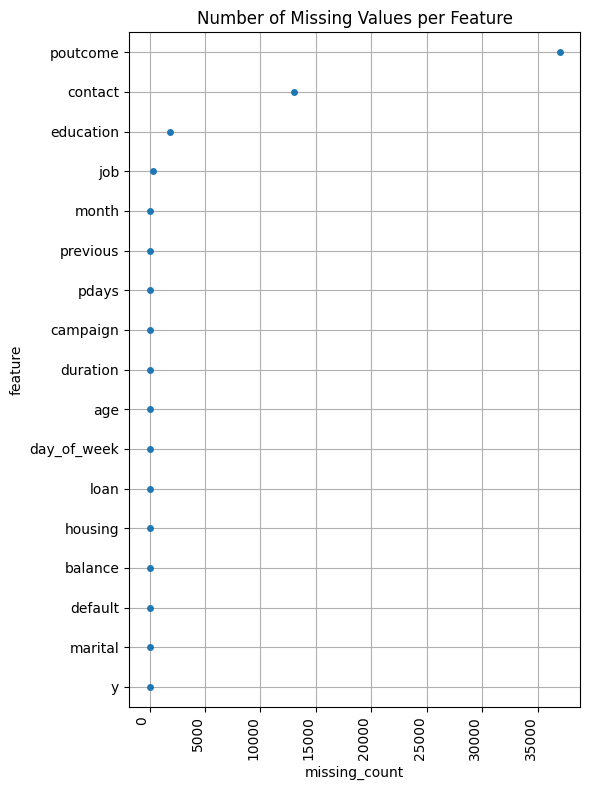

In [18]:
plt.figure(figsize=(6, 8))
sns.stripplot(
    y="feature",
    x="missing_count",
    data=missing_df
)
plt.title("Number of Missing Values per Feature")
plt.xticks(rotation=90, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


Kiểm tra giá trị unique của các cột có missing: missing xuất hiện ở các biến phân loại, và là NaN thật

In [19]:
for col in ["poutcome", "contact", "education", "job"]:
    print(col, df[col].unique())

poutcome [nan 'failure' 'other' 'success']
contact [nan 'cellular' 'telephone']
education ['tertiary' 'secondary' nan 'primary']
job ['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']


Kiểm tra logic nghiệp vụ giữa previous, pdays, poutcome:  Nếu chưa từng có campaign trước → không thể có kết quả campaign trước (previous = 0 --> poutcome = NaN)

In [20]:
df[["previous","pdays","poutcome","y"]].head()

,previous,pdays,poutcome,y
0,0,-1,NaN,no
1,0,-1,NaN,no
2,0,-1,NaN,no
3,0,-1,NaN,no
4,0,-1,NaN,no


Tạo biến đánh dấu missing của poutcome/ dùng để phân tích

In [21]:
df["poutcome_missing"] = df["poutcome"].isna().astype(int)

Kiểm tra mối liên hệ giữa missing và previous:

In [22]:
pd.crosstab(df["poutcome_missing"], df["previous"] > 0, normalize="index")

previous,False,True
poutcome_missing,,
0,0.000000,1.000000
1,0.999865,0.000135


So sánh tỷ lệ đăng ký giữa nhóm missing vs non-missing: Missing ảnh hưởng rõ rệt đến target 

In [23]:
df["target"] = (df["y"] == "yes").astype(int)
df.groupby(df["poutcome"].isna())["target"].mean()

poutcome
False    0.230611
True     0.091615
Name: target, dtype: float64

**EDA on Missing Values (Business Meaning):**  
- Các giá trị thiếu ở biến `poutcome` xuất hiện khi khách hàng chưa từng tham gia chiến dịch marketing trước đó (`previous = 0`, `pdays = -1`).  
- Missing values này không xuất hiện ngẫu nhiên mà phản ánh cấu trúc nghiệp vụ của dữ liệu.  
- Phân tích cho thấy nhóm khách hàng có `poutcome` không bị thiếu có tỷ lệ đăng ký cao hơn đáng kể so với nhóm bị thiếu.  
- Do đó, các giá trị thiếu ở `poutcome` mang ý nghĩa thông tin và được ghi nhận để xử lý ở bước preprocessing sau.


Xử lý sơ giá trị


In [24]:
df["poutcome"] = df["poutcome"].fillna("no_previous_campaign")
df["pdays_contacted"] = (df["pdays"] != -1).astype(int)
df["has_previous_campaign"] = (df["previous"] > 0).astype(int)

In [25]:
df["target"] = (df["y"] == "yes").astype(int)

df.groupby("poutcome")["target"].mean().sort_values(ascending=False)


poutcome
success                 0.647253
other                   0.166848
failure                 0.126097
no_previous_campaign    0.091615
Name: target, dtype: float64

**Handling Missing Values with Business Context:**  
- Các giá trị thiếu ở biến `poutcome` được gán nhãn là `no_previous_campaign`, phản ánh trường hợp khách hàng chưa từng tham gia chiến dịch marketing trước đó.  
- Cách xử lý này dựa trên phân tích EDA cho thấy missing values ở `poutcome` có mối liên hệ chặt chẽ với `previous = 0` và `pdays = -1`.  
- Kết quả sau khi xử lý cho thấy tỷ lệ đăng ký thay đổi hợp lý theo từng nhóm `poutcome`, xác nhận rằng việc xử lý missing giữ được ý nghĩa nghiệp vụ của dữ liệu.



**Target Distribution Analysis:**  
- Biến mục tiêu `y` có phân phối không cân bằng, với khoảng 88% khách hàng không đăng ký và chỉ khoảng 12% khách hàng đăng ký term deposit.  
- Đây là đặc điểm phổ biến trong các bài toán marketing ngân hàng và phản ánh thực tế nghiệp vụ.  
- Do đó, hiện tượng mất cân bằng lớp được ghi nhận trong giai đoạn EDA để làm cơ sở cho việc lựa chọn phương pháp đánh giá và xử lý phù hợp ở các bước modeling tiếp theo.


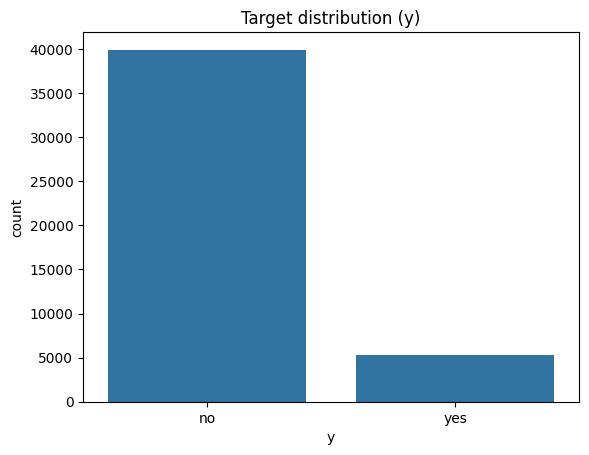

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [26]:
sns.countplot(x="y", data=df)
plt.title("Target distribution (y)")
plt.show()
df["y"].value_counts(normalize=True)

In [27]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


**Numerical Feature Distribution Analysis:**  
- Các biến số trong dữ liệu có phân phối không đối xứng và nhiều đuôi dài, phản ánh hành vi thực tế của khách hàng trong bối cảnh ngân hàng.  
- Một số biến như `balance`, `duration`, `campaign` và `previous` có nhiều giá trị cực đoan, tuy nhiên đây không phải lỗi dữ liệu mà là đặc điểm tự nhiên của dữ liệu hành vi.  
- Ngoài ra, các biến như `pdays` và `previous` mang tính mã nghiệp vụ hơn là biến số thuần túy.  
- Những đặc điểm này được ghi nhận trong giai đoạn EDA để làm cơ sở cho các bước xử lý và mô hình hóa tiếp theo.


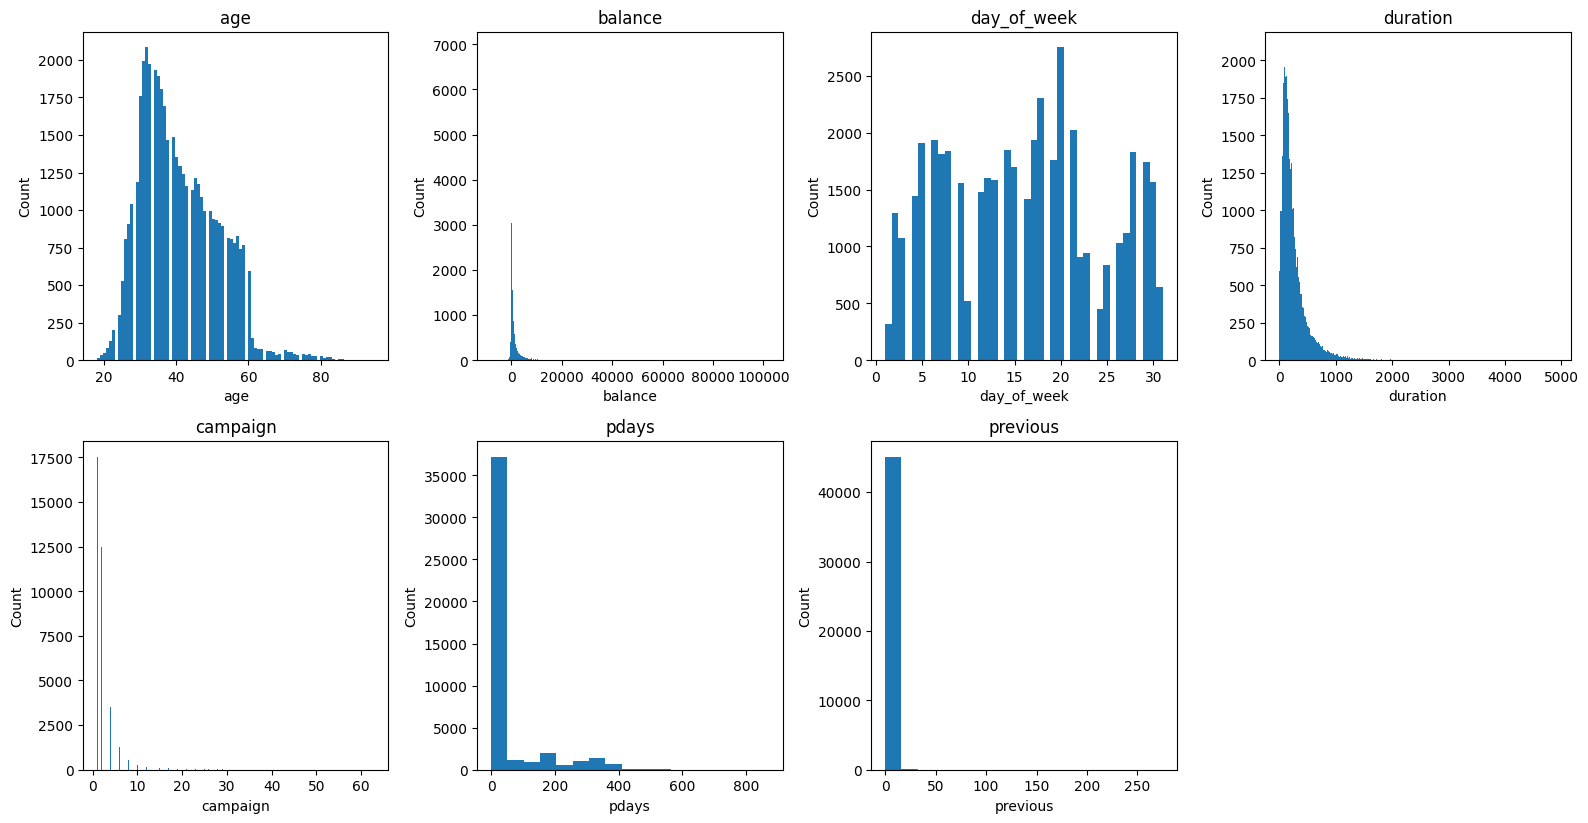

In [28]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[col], bins="auto")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


**Outlier Analysis:**  
- Nhiều biến số trong dữ liệu xuất hiện các giá trị bị coi là outlier theo tiêu chí thống kê (IQR).  
- Tuy nhiên, các outlier này phản ánh hành vi thực tế của khách hàng ngân hàng (ví dụ: số dư lớn, thời lượng cuộc gọi dài, số lần liên hệ nhiều) và không phải là lỗi dữ liệu 

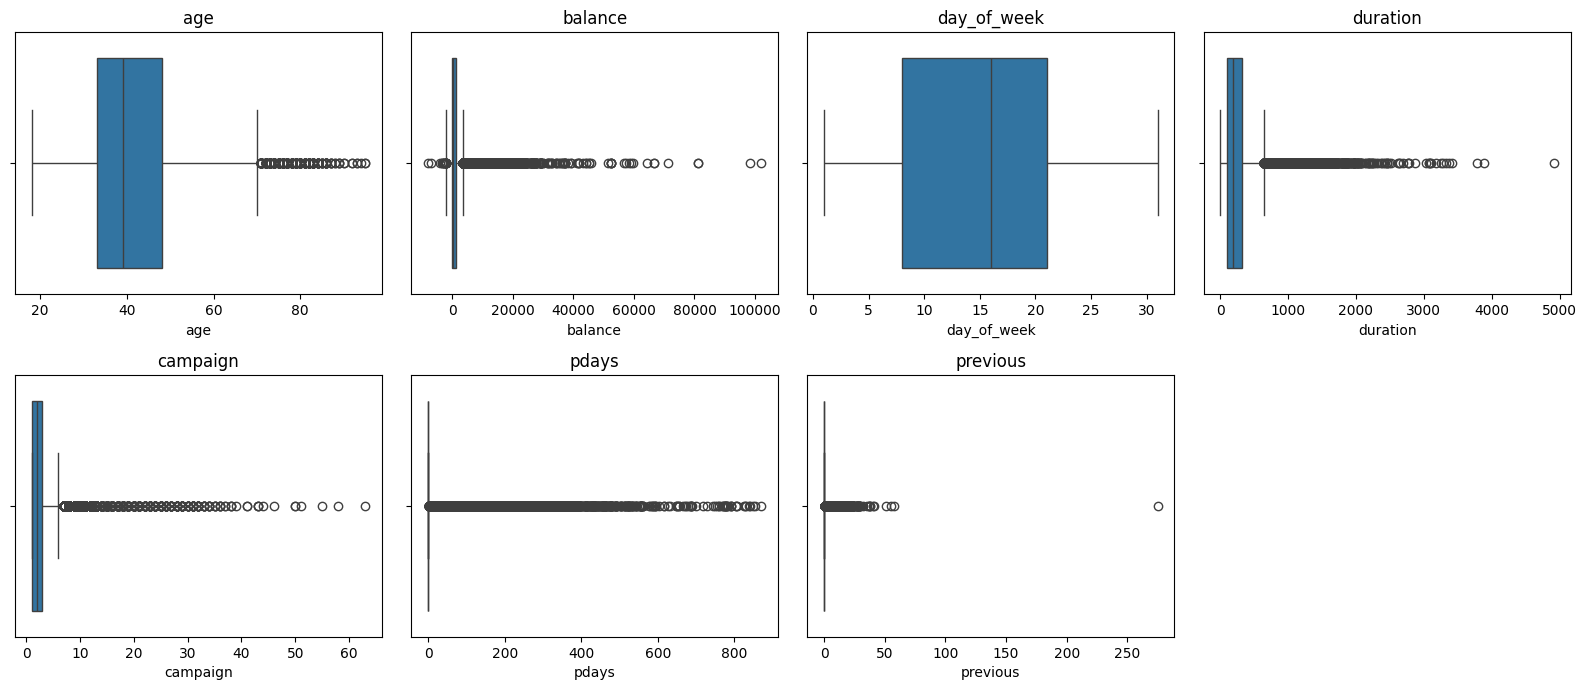

In [29]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

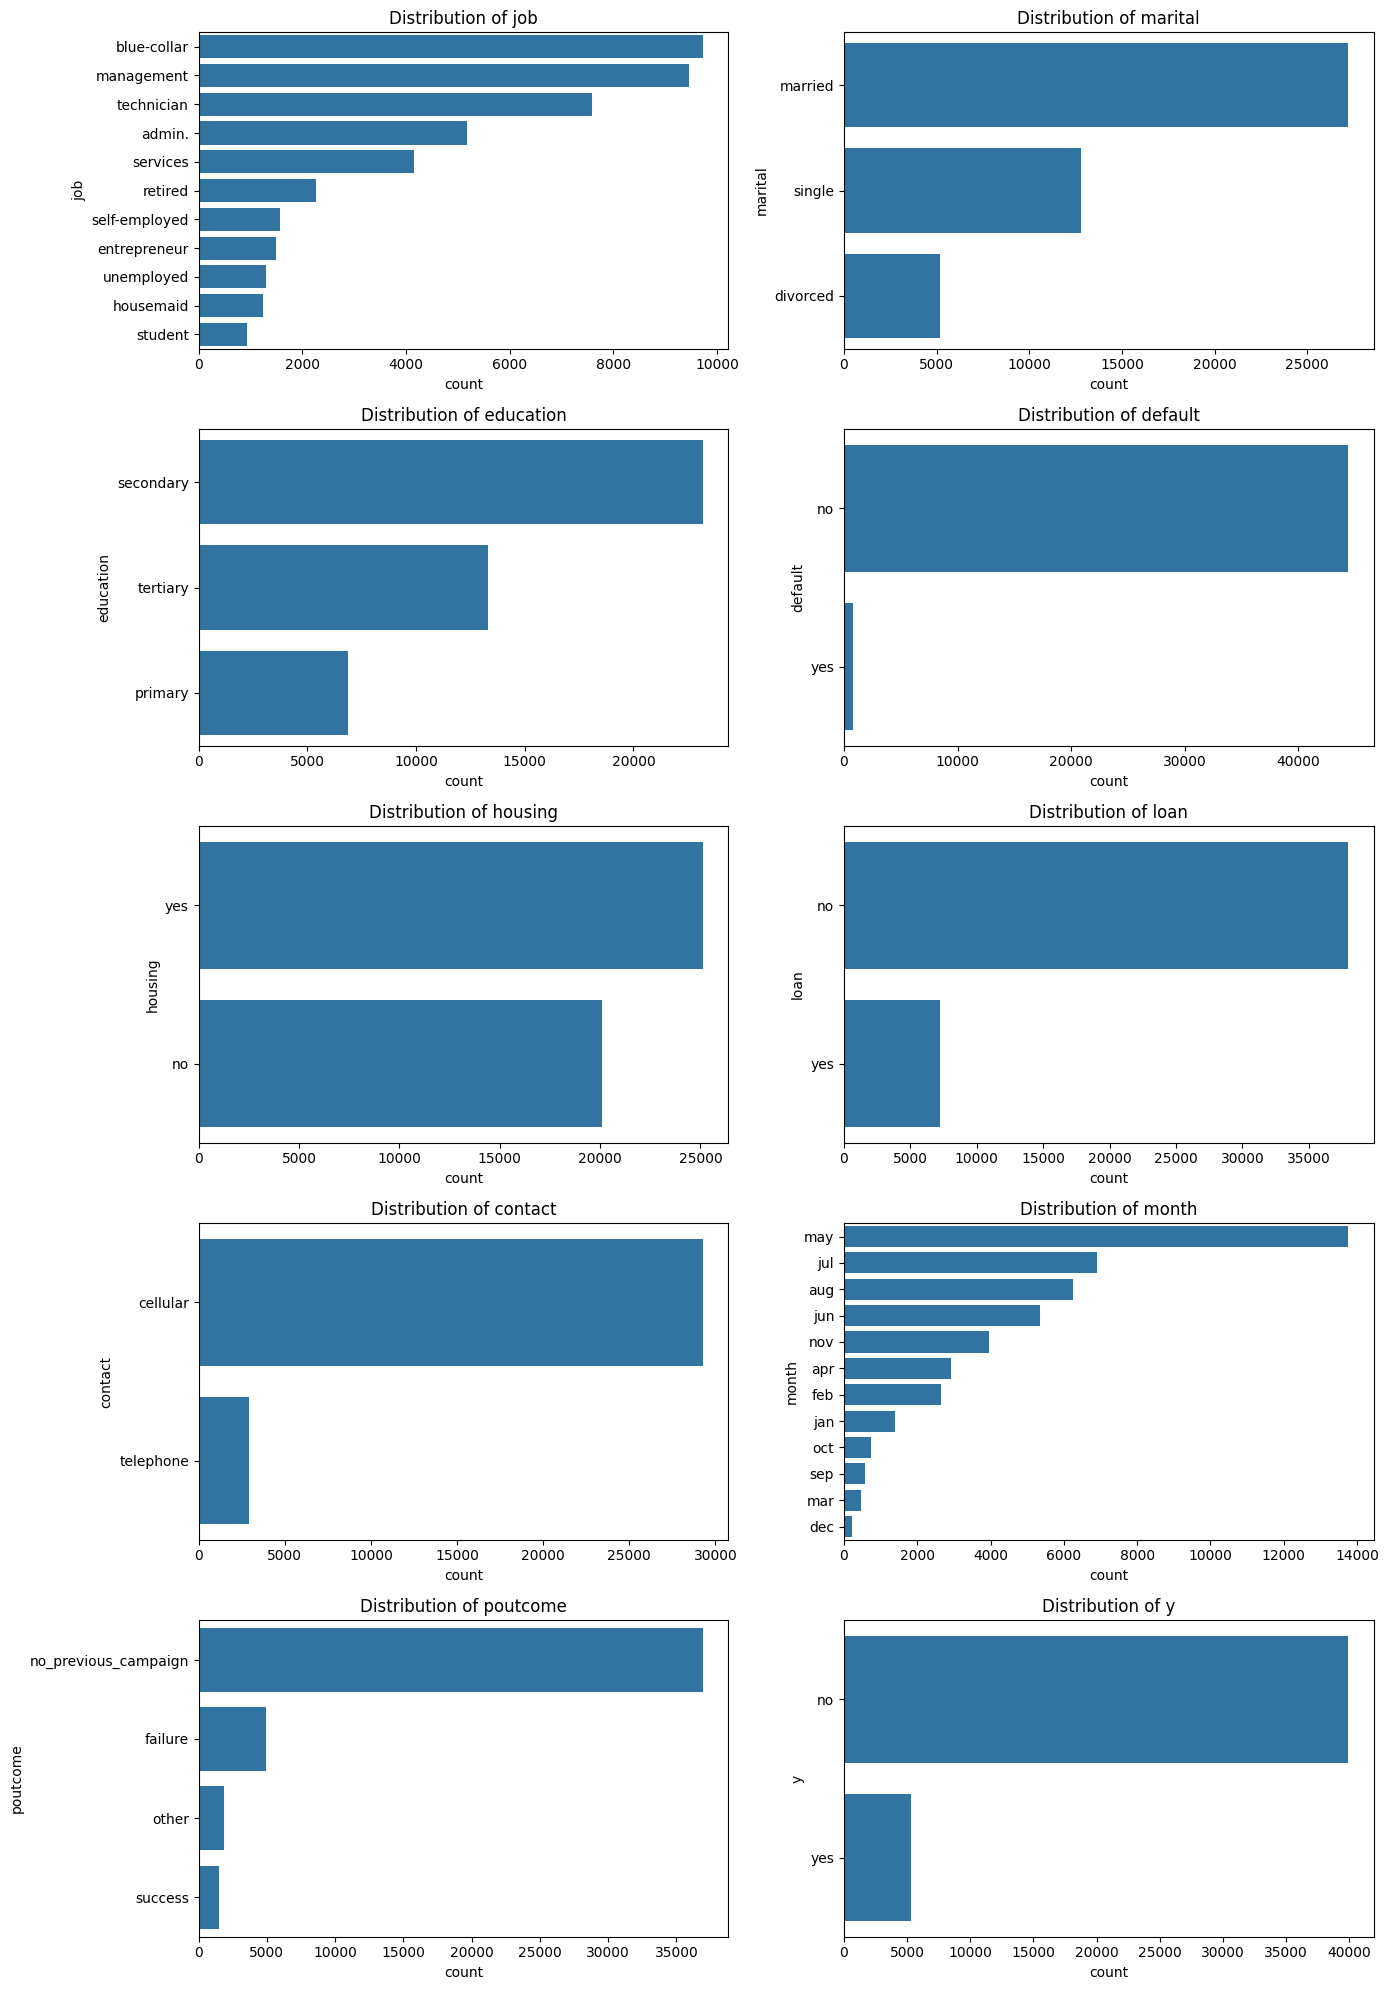

In [30]:
n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 4 * n_rows)
)

axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(
        y=col,
        data=df,
        order=df[col].value_counts().index,
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")

for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


**Categorical Features vs Target:**  
- Biểu đồ cho thấy tỷ lệ đăng ký khác nhau rõ rệt giữa các nhóm của các biến phân loại như `job`, `education`, `contact` và `poutcome`.  
- Các biến phân loại mang thông tin quan trọng liên quan đến hành vi đăng ký của khách hàng và có tiềm năng đóng góp vào mô hình dự đoán.


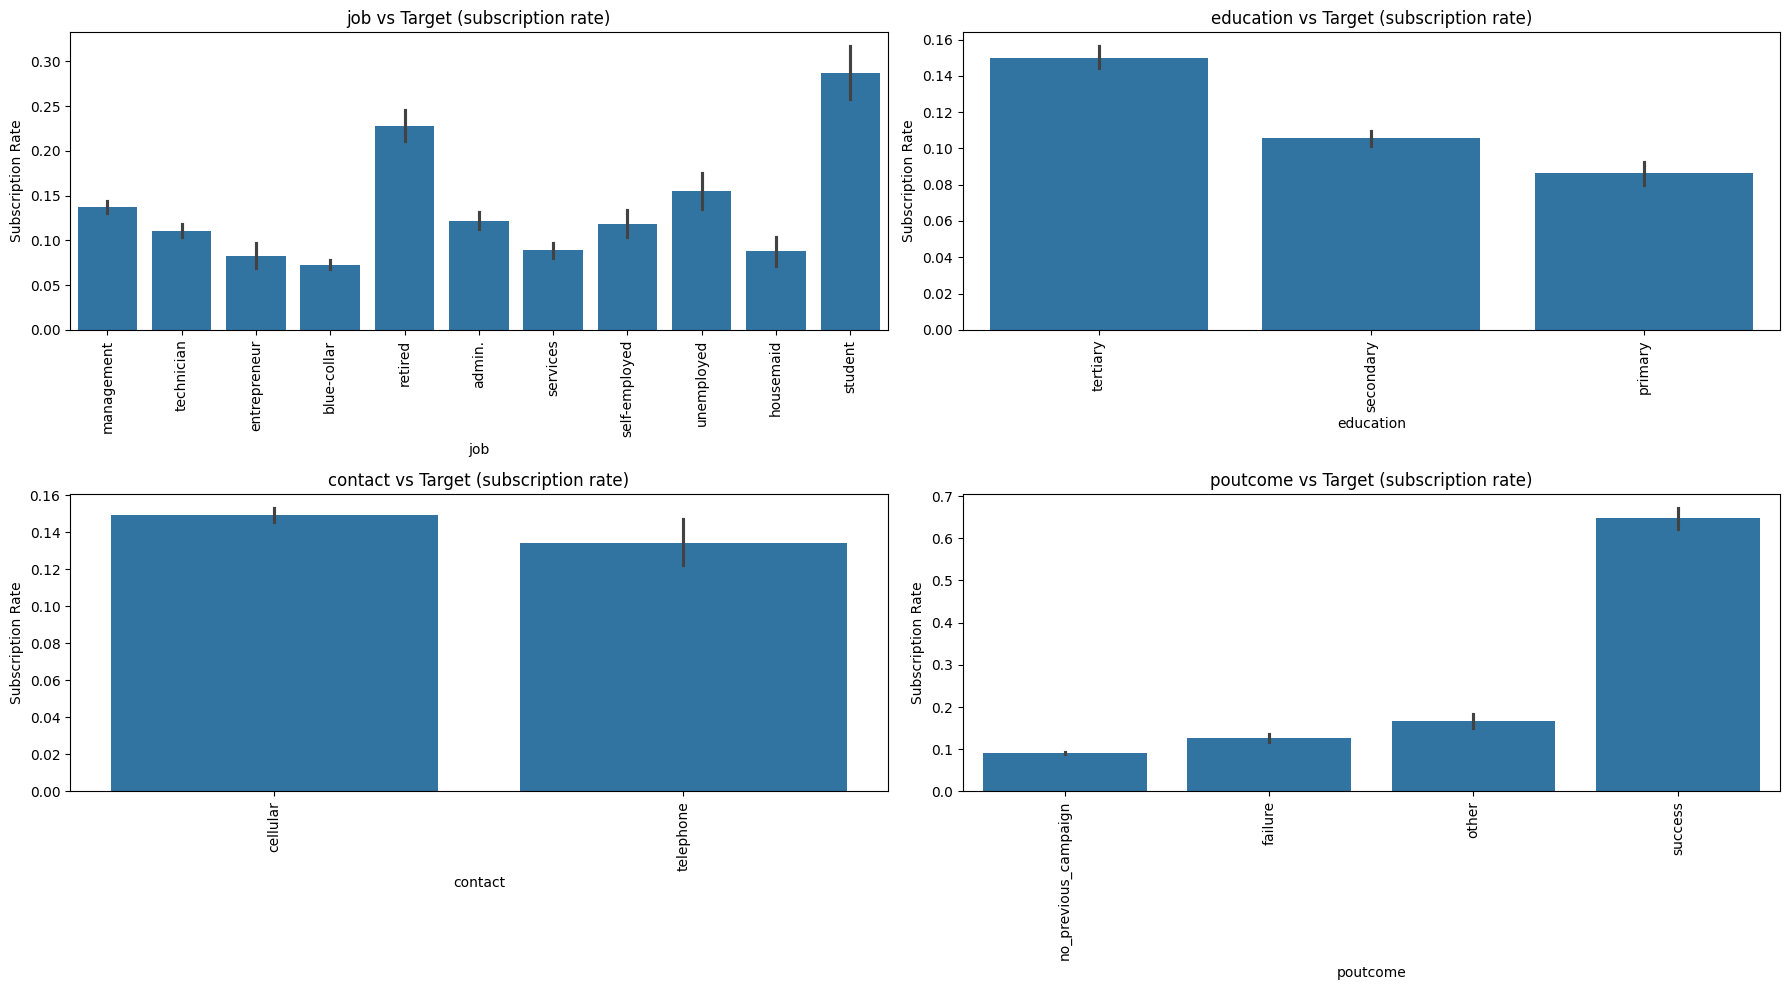

In [31]:
cols = ["job", "education", "contact", "poutcome"]

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(18, 10)
)

axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.barplot(
        x=col,
        y=(df["y"] == "yes").astype(int),
        data=df,
        ax=ax
    )
    ax.set_title(f"{col} vs Target (subscription rate)")
    ax.set_xlabel(col)
    ax.set_ylabel("Subscription Rate")
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


**Correlation Analysis:**  
- Ma trận tương quan cho thấy hầu hết các biến số có mối quan hệ tuyến tính yếu với nhau, cho thấy mức độ phụ thuộc thấp giữa các đặc trưng.  
- Cặp biến `pdays` và `previous` có tương quan dương ở mức trung bình, phản ánh mối liên hệ nghiệp vụ giữa lịch sử liên hệ và số lần contact trước đó.  
- Không phát hiện cặp biến nào có tương quan cao gây ra vấn đề đa cộng tuyến, do đó các biến số có thể được giữ lại cho các bước mô hình hóa tiếp theo.


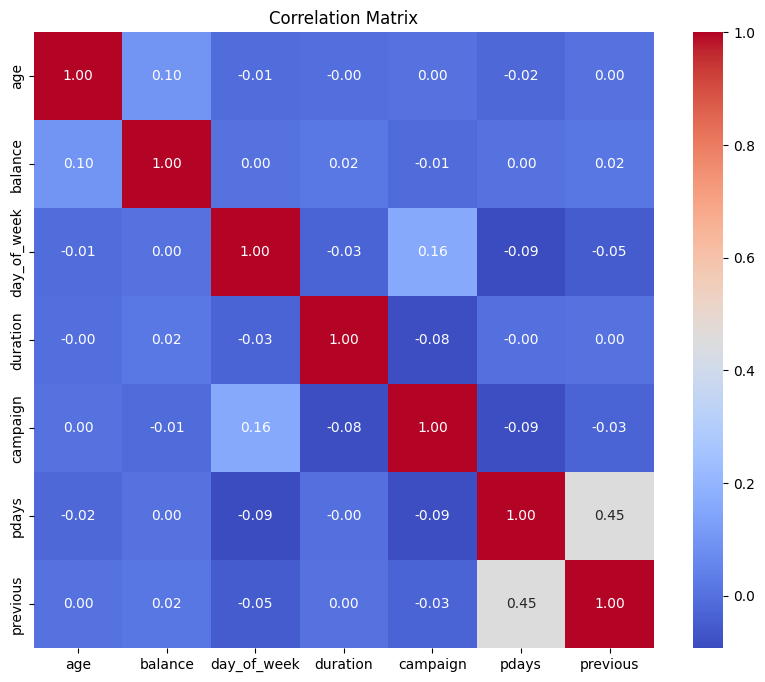

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**Previous Contact vs Target Analysis:**  
- Biến `pdays_contacted` được tạo để phân biệt khách hàng đã từng được liên hệ trước đó và khách hàng mới.  
- Biểu đồ cho thấy sự khác biệt rõ ràng về phân bố biến mục tiêu giữa hai nhóm, trong đó nhóm khách hàng đã từng được liên hệ có số lượng đăng ký cao hơn về mặt tuyệt đối.  


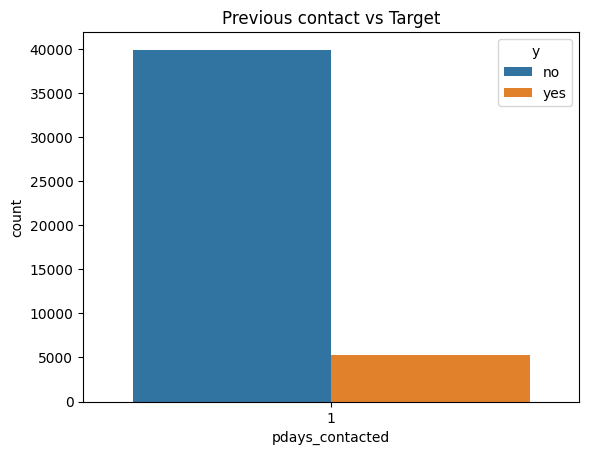

In [33]:
df["pdays_contacted"] = (df["pdays"] != 999).astype(int)

sns.countplot(x="pdays_contacted", hue="y", data=df)
plt.title("Previous contact vs Target")
plt.show()


In [34]:
df.to_csv("../data/processed/bank_marketing_raw.csv", index=False)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'poutcome_missing', 'target',
       'pdays_contacted', 'has_previous_campaign'],
      dtype='object')

## CUSTOMER ANALYSIS

In [ ]:
cus_df = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'target']]

In [79]:
for col in cus_df.columns:
    print(f"\n===== Column: {col} =====")
    pct = pd.crosstab(df[col], df['target'], normalize='index').sort_values(by = [1], ascending=[False])
    print(pct.round(3))


===== Column: age =====
target      0      1
age                 
93      0.000  1.000
92      0.000  1.000
90      0.000  1.000
85      0.200  0.800
87      0.250  0.750
..        ...    ...
44      0.918  0.082
50      0.923  0.077
88      1.000  0.000
89      1.000  0.000
94      1.000  0.000

[77 rows x 2 columns]

===== Column: job =====
target             0      1
job                        
student        0.713  0.287
retired        0.772  0.228
unemployed     0.845  0.155
management     0.862  0.138
admin.         0.878  0.122
self-employed  0.882  0.118
technician     0.889  0.111
services       0.911  0.089
housemaid      0.912  0.088
entrepreneur   0.917  0.083
blue-collar    0.927  0.073

===== Column: marital =====
target        0      1
marital               
single    0.851  0.149
divorced  0.881  0.119
married   0.899  0.101

===== Column: education =====
target         0      1
education              
tertiary   0.850  0.150
secondary  0.894  0.106
primary    0.914  0

**ĐỘ TUỔI**

**Phân nhóm độ tuổi theo giai đoạn vòng đời tài chính của khách hàng**

Các nhóm tuổi được chia thành các giai đoạn trong cuộc đời với:
- Formative Years: từ 0 đến 18 tuổi
- Early Career: từ 18 đến 25 tuổi
- Mid-Career: từ 25 đến 45 tuổi
- 'Pre-Retirement: từ 45 đến 65 tuổi
- Retirement: 65 tuổi trở lên

Phân chia tuổi khách hàng theo phương pháp này cho thấy sự **thiên lệch** trong số lượng khách hàng ở mỗi nhóm tuổi khi nhóm Mid-Career chiếm hơn 65% toàn bộ khách hàng, nhóm Pre-Retirement chiếm khoảng 30%. Trong khi tổng khách hàng trong 3 nhóm tuổi còn lại chỉ chiếm 5%


In [80]:
cus_df['age_group_1'] = pd.cut(cus_df['age'], bins= [0, 18, 25, 45, 65, 120],
                             labels= ['Formative Years', 'Early Career', 'Mid-Career', 'Pre-Retirement', 'Retirement'],
                             right= True)
ag1_count = cus_df.groupby('age_group_1').size()
ag1_count = pd.DataFrame(ag1_count).reset_index()
ag1_count


C:\Users\ACER\AppData\Local\Temp\ipykernel_18424\234245647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df['age_group_1'] = pd.cut(cus_df['age'], bins= [0, 18, 25, 45, 65, 120],
C:\Users\ACER\AppData\Local\Temp\ipykernel_18424\234245647.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ag1_count = cus_df.groupby('age_group_1').size()


,age_group_1,0
0,Formative Years,12
1,Early Career,1324
2,Mid-Career,29427
3,Pre-Retirement,13697
4,Retirement,751


**Nhận xét:**

Tỷ lệ thành công của chiến dịch ở nhóm Formative Years là cao nhất với 58%. Kế đến là nhốm Retirement và Early Career với 43% và 24%. Hai nhóm tuổi Pre-Retirement và Mid-Career chỉ đạt tỷ lệ thành công ở mức 11%.

Khi phân nhóm độ tuổi theo chu kỳ tài chính, số lượng khách hàng giữa các nhóm có sự chênh lệch đáng kể. Mặc dù chu kỳ tài chính phù hợp cho mục đích diễn giải, nhưng chưa tối ưu để đánh giá hiệu quả chiến dịch do sự mất cân bằng về phân bố mẫu. Vì vậy, bên cạnh tỷ lệ thành công, cần xem xét thêm các thước đo chuẩn hóa khác để đánh giá toàn diện hơn tác động của độ tuổi đến khả năng subscribe deposit.

In [81]:

pct_age = pd.crosstab(cus_df['age_group_1'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_age = pd.DataFrame(pct_age.reset_index())

pct_age

target,age_group_1,0,1
0,Formative Years,0.42,0.58
1,Retirement,0.57,0.43
2,Early Career,0.76,0.24
3,Pre-Retirement,0.89,0.11
4,Mid-Career,0.89,0.11


Text(0.5, 1.0, 'Subcription Rate By Age Group')

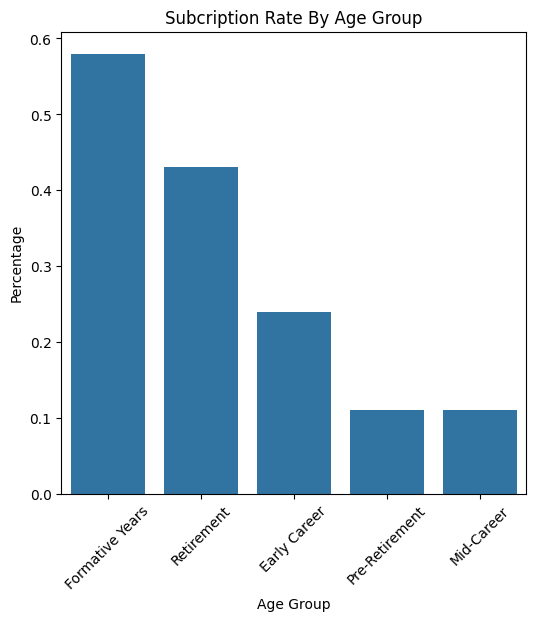

In [82]:
order = pct_age.sort_values(by=1, ascending=False)['age_group_1']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_age, x= 'age_group_1', y= 1, order=order)
plt.tick_params(axis='x', rotation= 45)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Age Group')

**Phân nhóm độ tuổi sử dụng Decision Tree nhằm xác định các ngưỡng phân tách tối ưu theo dữ liệu**

In [83]:
age_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)
age_tree.fit(df[['age']], df['target'])


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",0.05
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre


(process:18864): Pango-CRITICAL **: 12:50:16.356: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:18864): Pango-CRITICAL **: 12:50:16.356: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:18864): Pango-CRITICAL **: 12:50:16.356: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:18864): Pango-CRITICAL **: 12:50:16.356: pango_font_description_get_family: assertion 'desc != NULL' failed



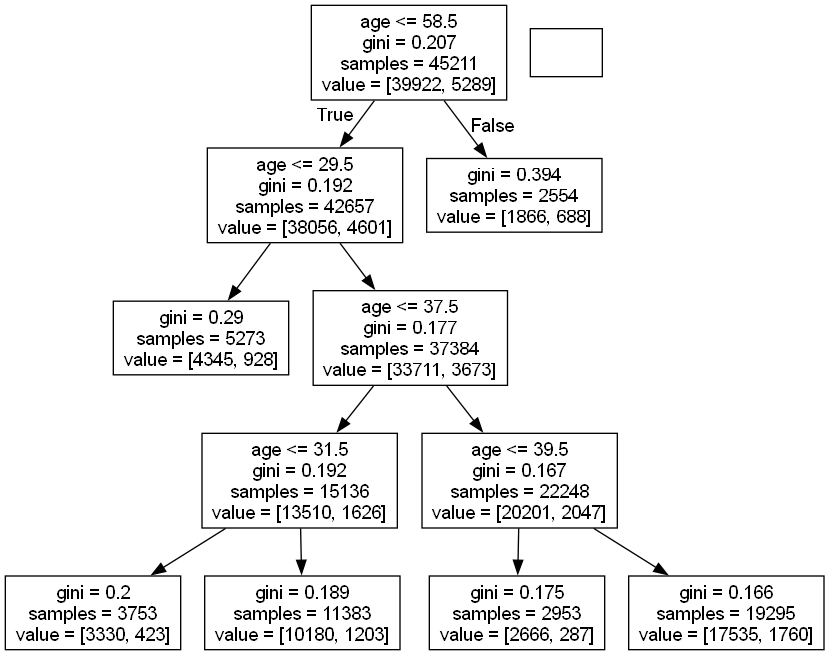

In [63]:
## Biểu diễn cây quyết định
dcs_tree = tree.export_graphviz(age_tree, out_file = None, feature_names = ['age'])
graph    = pdp.graph_from_dot_data(dcs_tree)
Image(graph.create_png())

**Nhận xét:**

Từ kết quả của Cây quyết định, độ tuổi khách hàng được chia thành 4 nhóm:
- Từ 0 đến 29 tuổi (chiếm 12%)
- Từ 29 tuổi đến 37 tuổi (chiếm 33%)
- Từ 37 tuổi đến 58 tuổi (chiếm 49%)
- Trên 58 tuổi (chiếm 6%)

In [64]:
cus_df.loc[:,'age_group_2'] = pd.cut(cus_df.loc[:,'age'], bins= [0, 29.5, 37.5, 58.5, 120],
                             labels= ['< 29', '29 - 37', '37-58', '> 58'],
                             right= True)
ag2_count = cus_df.groupby('age_group_2', observed=True).size()
ag2_count = pd.DataFrame(ag2_count).reset_index()
ag2_count

C:\Users\ACER\AppData\Local\Temp\ipykernel_18424\1322626860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df.loc[:,'age_group_2'] = pd.cut(cus_df.loc[:,'age'], bins= [0, 29.5, 37.5, 58.5, 120],


,age_group_2,0
0,< 29,5273
1,29 - 37,15136
2,37-58,22248
3,> 58,2554


**Nhận xét:**

Nhóm khách hàng trên 58 tuổi có tỷ lệ đăng ký tiền gửi có kỳ hạn cao nhất, rơi vào 27%

Nhóm khách hàng dưới 29 tuổi có tỷ lệ đăng ký tiền gửi có kỳ hạn khoảng 18%

Các nhóm 29-37 tuổi và 37-58 tuối chỉ đạt tỷ lệ 11% và 9%

--> Nhóm khách hàng trên 58 tuổi có xu hướng đăng ký cao hơn, tuy nhiên mối quan hệ giữa độ tuổi và khả năng đăng ký tiền gửi có kỳ hạn vẫn là chưa rõ ràng

--> Độ tuổi chỉ đóng vai trò hỗ trợ trong phân tích và cần được kết hợp với các biến khác để đánh giá hiệu quả toàn diện hơn

In [65]:
pct_age = pd.crosstab(cus_df['age_group_2'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_age = pd.DataFrame(pct_age.reset_index())
pct_age

target,age_group_2,0,1
0,> 58,0.73,0.27
1,< 29,0.82,0.18
2,29 - 37,0.89,0.11
3,37-58,0.91,0.09


Text(0.5, 1.0, 'Subcription Rate By Age Group')

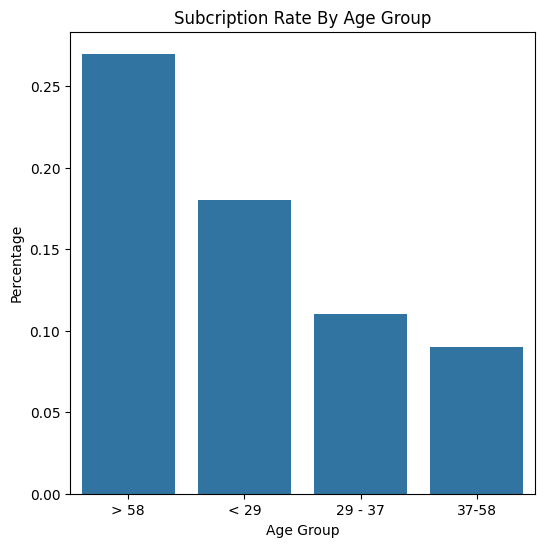

In [66]:
order = pct_age.sort_values(by=1, ascending=False)['age_group_2']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_age, x= 'age_group_2', y= 1, order=order)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Age Group')

**BALANCE**

**Phân nhóm số dư tài khoản bằng optimal binning**

Biến số dư tài khoản được chia khoảng bằng phương pháp optimal binning nhằm tối đa hóa sự khác biệt về tỷ lệ đăng ký tiền gửi giữa các nhóm

Số dư tài khoản của khách hàng được chia thành các khoảng:
- Từ vô cùng đến - 46.5
- Từ -46.5 đến 60.5
- Từ 60.5 đến 798.5
- Từ 798.5 đến 1578.5
- Lớn hơn 1578.5

Các khoảng chia này cho thấy event rate (tỷ lệ khách hàng đăng ký) ở các bin phân biệt rõ với nhau và tăng đều theo bin

Kích thước của các bin cũng là hợp lý, bin lớn nhất chiến khoảng 39% - vẫn chấp nhận được ==> tại sao ?

Không có hiện tượng thiên lệch mẫu khi bin có event rate cao nhất vẫn có mức count chỉ khoảng 23%


In [67]:
from optbinning import OptimalBinning

optb = OptimalBinning(
    name="balance",
    dtype="numerical",
    max_n_bins=5
)

optb.fit(cus_df['balance'], cus_df['target'])

binning_table = optb.binning_table.build()
binning_table


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -46.50)",3193,0.070624,3027,166,0.051989,0.882041,0.039195,0.004747
1,"[-46.50, 60.50)",7628,0.168720,7034,594,0.077871,0.450333,0.028770,0.003566
2,"[60.50, 798.50)",17577,0.388777,15614,1963,0.111680,0.052396,0.001046,0.000131
3,"[798.50, 1578.50)",6369,0.140873,5521,848,0.133145,-0.147865,0.003259,0.000407
4,"[1578.50, inf)",10444,0.231006,8726,1718,0.164496,-0.396152,0.042091,0.005227
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,45211,1.000000,39922,5289,0.116985,,0.114360,0.014078


**Nhận xét**

Nhóm khách hàng có số dư tài khoản trên 1578.5 có tỷ lệ đăng ký tiền gửi có kỳ hạn cao nhất với 16%

Tỷ lệ đăng ký có xu hướng tăng dần theo mức số dư tài khoản, từ 5% ở mức thấp nhất lên đến khoảng 16% ở nhóm có số dư cao

--> Balance có mối liên hệ tích cực với khả năng đăng ký tiền gửi. Tuy nhiên mức chênh lệch giữa các nhóm là không quá lớn, cho thấy balance không phải là yếu tố duy nhất ảnh hưởng đến quyết định của khách hàng

In [68]:
cus_df.loc[:, 'balance_group'] = pd.cut(cus_df.loc[:, 'balance'], bins= [-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],
                                 labels= ['< -46.5', '-46.5 - 60.5', '60.5 - 798.5', '798.5 - 1578.5', '> 1578.5'],
                                 right= False)

pct_balance = pd.crosstab(cus_df['balance_group'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_balance = pd.DataFrame(pct_balance.reset_index())
pct_balance

C:\Users\ACER\AppData\Local\Temp\ipykernel_18424\5369981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df.loc[:, 'balance_group'] = pd.cut(cus_df.loc[:, 'balance'], bins= [-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],


target,balance_group,0,1
0,> 1578.5,0.84,0.16
1,798.5 - 1578.5,0.87,0.13
2,60.5 - 798.5,0.89,0.11
3,-46.5 - 60.5,0.92,0.08
4,< -46.5,0.95,0.05


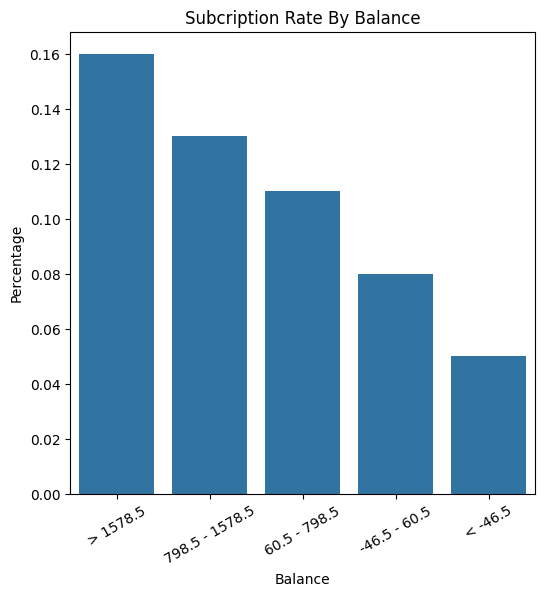

In [69]:
order = pct_balance.sort_values(by=1, ascending=False)['balance_group']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_balance, x= 'balance_group', y= 1, order=order)
plt.xlabel('Balance')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Balance')
plt.tick_params(axis= 'x', rotation= 30)